#**Packages**

In [ ]:
import pandas as pd
import numpy as np
import itertools

import datetime # to show the date and time
import timeit # to calculate the time consumption

import gzip

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from scipy.stats import bernoulli

import random

from scipy.stats import multivariate_normal
from scipy import linalg

import datetime # to show the date and time
import timeit # to calculate the time consumption

from collections import deque
import six
import json

#**MovieLens 10M - Current**

In [ ]:
def movie_preprocessing(movie):
    movie_col = list(movie.columns)
    movie_tag = [doc.split('|') for doc in movie['tag']]
    tag_table = {token: idx for idx, token in enumerate(set(itertools.chain.from_iterable(movie_tag)))}
    movie_tag = pd.DataFrame(movie_tag)
    tag_table = pd.DataFrame(tag_table.items())
    tag_table.columns = ['Tag', 'Index']

    # use one-hot encoding for movie genres (here called tag)
    tag_dummy = np.zeros([len(movie), len(tag_table)])

    for i in range(len(movie)):
        for j in range(len(tag_table)):
            if tag_table['Tag'][j] in list(movie_tag.iloc[i, :]):
                tag_dummy[i, j] = 1

    # combine the tag_dummy one-hot encoding table to original movie files
    movie = pd.concat([movie, pd.DataFrame(tag_dummy)], 1)
    movie_col.extend(['tag' + str(i) for i in range(len(tag_table))])
    movie.columns = movie_col
    movie = movie.drop('tag', 1)
    return movie


def feature_extraction(data):
    # actions: we use top 50 movies as our actions for recommendations
    actions = data.groupby('movie_id').size().sort_values(ascending=False)[:1000]
    actions = list(actions.index)

    # user_feature: tags they've watched for non-top-50 movies normalized per user
    user_feature = data[~data['movie_id'].isin(actions)]
    user_feature = user_feature.groupby('user_id').aggregate(np.sum)
    user_feature = user_feature.drop(['movie_id', 'rating', 'timestamp'], 1)
    user_feature = user_feature.div(user_feature.sum(axis=1), axis=0)

    # streaming_batch: the result for testing bandit algrorithms
    top50_data = data[data['movie_id'].isin(actions)]
    top50_data = top50_data.sort_values('timestamp', ascending=1)
    streaming_batch = top50_data['user_id']

    # reward_list: if rating >=3, the user will watch the movie
    top50_data['reward'] = np.where(top50_data['rating'] >= 3, 1, 0)
    reward_list = top50_data[['user_id', 'movie_id', 'reward']]
    reward_list = reward_list[reward_list['reward'] == 1]
    return streaming_batch, user_feature, actions, reward_list

def main_data():
    # read and preprocess the movie data
    movie = pd.read_table('drive/MyDrive/P2/MovieLens-Dataset/10M/movies.dat', sep='::', names=['movie_id', 'movie_name', 'tag'], engine='python')
    movie = movie_preprocessing(movie)

    # read the ratings data and merge it with movie data
    rating = pd.read_table("drive/MyDrive/P2/MovieLens-Dataset/10M/ratings.dat", sep="::",
                           names=["user_id", "movie_id", "rating", "timestamp"], engine='python')
    data = pd.merge(rating, movie, on="movie_id")

    # extract feature from our data set
    streaming_batch, user_feature, actions, reward_list = feature_extraction(data)
    streaming_batch.to_csv("streaming_batch.csv", sep='\t', index=False)
    user_feature.to_csv("user_feature.csv", sep='\t')
    pd.DataFrame(actions, columns=['movie_id']).to_csv("actions.csv", sep='\t', index=False)
    reward_list.to_csv("reward_list.csv", sep='\t', index=False)

    action_context = movie[movie['movie_id'].isin(actions)]
    action_context.to_csv("action_context.csv", sep='\t', index = False)

    movie.to_csv("movie.csv", sep='\t', index=False)

__name__ = '__main__'
if __name__ == '__main__':
    main_data()

In [ ]:
def get_data():
    # streaming_batch = pd.read_csv('streaming_batch.csv', sep='\t', names=['user_id'], engine='c')
    streaming_batch = pd.read_csv('streaming_batch.csv', sep='\t', header=0, engine='c')
    user_feature = pd.read_csv('user_feature.csv', sep='\t', header=0, index_col=0, engine='c')
    actions_id = list(pd.read_csv('actions.csv', sep='\t', header=0, engine='c')['movie_id'])
    reward_list = pd.read_csv('reward_list.csv', sep='\t', header=0, engine='c')
    action_context = pd.read_csv('action_context.csv', sep='\t', header=0, engine='c')

    movie = pd.read_csv('movie.csv', sep='\t', header=0, engine='c')

    # actions = actions_id #[]
    # for key in actions_id:
        # print(key)
        # action = Action(key) #?
        # actions.append(action)
    return streaming_batch, user_feature, actions_id, reward_list, action_context #, movie

# action_context --> 
# actions -->
# streaming_batch -->
# reward_list --> user_id, movie_id, reward, only ones are kept
# user_feature --> users_id, tag0 ..., tag19, only unique users are kept # user_feature.index = user_id
# movie -->


In [ ]:
streaming_batch, user_feature, actions, reward_list, action_context = get_data() #, movie
# streaming_batch_small = streaming_batch.iloc[0:10000]

In [ ]:
action_context

In [ ]:
#How many users are there in our experiment
jjj = 10222
len(streaming_batch.iloc[0:jjj]['user_id'].unique())

#**Policies with Class**

In [ ]:
def policy_generation(bandit, actions, reduct_matrix):
    org_dim = 120
    red_dim = 60
    if bandit == 'BCMABRP':
        policy = BCMABRP(org_dim, red_dim, reduct_matrix, delta=0.5, R=0.01, lambd=0.5)
        policy.initialization()
    elif bandit == 'CBRAP':
        policy = CBRAP(org_dim, red_dim, reduct_matrix, alpha = 0.5)
        policy.initialization()
    elif bandit == 'LinearTS':
        policy = LinearTS(org_dim, delta=0.5, R=0.01, epsilon=0.5)
        policy.initialization()
    elif bandit == 'LinUCB':
        policy = LinUCB(org_dim, alpha=0.5)
        policy.initialization()
    elif bandit == 'random':
        policy = 0

    return policy

def policy_evaluation(policy, bandit, streaming_batch, user_feature, reward_list, actions, action_features, times): # action_context=None
    # times = 10000 #len(streaming_batch)
    seq_error = np.zeros(shape=(times, 1))
    
    action_context_dict = {}
    for action_id in actions: #movie_id :)
         action_context_dict[action_id] = np.array(action_features[action_features['movieid'] == action_id])[0][1:]    
    if bandit in ['BCMABRP', 'CBRAP', 'LinearTS', 'LinUCB']:
        
        j = 0 #
        t = 0 #
        while t < times: #
            j = j+1 #
            if len(np.array(user_feature[user_feature.index == streaming_batch.iloc[j, 0]])) == 0: #
                print("time with no user:" + str(j))
                continue
            feature = np.array(user_feature[user_feature.index == streaming_batch.iloc[j, 0]])[0] #
            full_context = {}
            for action_id in actions: #movie_id :)
                full_context[action_id] = np.append(action_context_dict[action_id], feature) #feature
            # history_m, action_t = policy.get_action(full_context, 1)
            action_t = policy.get_action(full_context, 1)
            watched_list = reward_list[reward_list['user_id'] == streaming_batch.iloc[j, 0]] #
            if action_t not in list(watched_list['movie_id']):
                
                policy.reward(0.0)
                if t == 0:
                    seq_error[t] = 1.0
                else:
                    seq_error[t] = seq_error[t - 1] + 1.0

            else:
                
                policy.reward(1.0)
                if t > 0:
                    seq_error[t] = seq_error[t - 1]

            
            t = t+1 #
        print("jj = " + str(j))
    elif bandit == 'random':
        
        j = 0
        t = 0
        while t < times:
            j = j+1
            if len(np.array(user_feature[user_feature.index == streaming_batch.iloc[j, 0]])) == 0:
                print("time in random with no user:" + str(j))
                continue
            action_t = actions[np.random.randint(0, len(actions)-1)]
            watched_list = reward_list[reward_list['user_id'] == streaming_batch.iloc[j, 0]]
            if action_t not in list(watched_list['movie_id']):
                if t == 0:
                    seq_error[t] = 1.0
                else:
                    seq_error[t] = seq_error[t - 1] + 1.0
            else:
                if t > 0:
                    seq_error[t] = seq_error[t - 1]
            t = t+1
    return seq_error


In [ ]:
class LinearTS():

    def __init__(self, context_dimension, delta=0.5, R=0.01, epsilon=0.5):
        super(LinearTS, self).__init__()
        self.context_dimension = context_dimension
        self.random_state = np.random.RandomState()

        # # 0 < delta < 1
        # if not isinstance(delta, float):
        #     raise ValueError("delta should be float")
        # elif (delta < 0) or (delta >= 1):
        #     raise ValueError("delta should be in (0, 1]")
        # else:
        #     self.delta = delta

        # # R > 0
        # if not isinstance(R, float):
        #     raise ValueError("R should be float")
        # elif R <= 0:
        #     raise ValueError("R should be positive")
        # else:
        #     self.R = R  # pylint: disable=invalid-name

        # # 0 < epsilon < 1
        # if not isinstance(epsilon, float):
        #     raise ValueError("epsilon should be float")
        # elif (epsilon < 0) or (epsilon > 1):
        #     raise ValueError("epsilon should be in (0, 1)")
        # else:
        #     self.epsilon = epsilon

        # self.nu = R * np.sqrt((24 / epsilon)*self.context_dimension*np.log(1 / delta))
        self.nu = 0.5

        self.model_param_memory = deque(maxlen = 1)
        self.history_memory = deque(maxlen = 1)

    def update_history(self, hst): # (context, recommendatin_id)
        self.history_memory.append(hst)
        # return self.history_memory

    def update_model_param(self, param): # (B, f, inv_B)
        self.model_param_memory.append(param)

    def initialization(self):
        B = np.identity(self.context_dimension)
        # mu_hat = np.zeros((self.context_dimension, 1))
        f = np.zeros((self.context_dimension, 1))
        inv_B = np.linalg.inv(B) #.astype(np.float32)
        # print(self.model_param_memory)
        self.update_model_param((B, f, inv_B))
        # print(self.model_param_memory)

    def get_score(self, context):
        action_ids = list(six.viewkeys(context))
        context_array = np.asarray([context[action_id] for action_id in action_ids])
        
        B = self.model_param_memory[0][0]
        f = self.model_param_memory[0][1]
        inv_B = self.model_param_memory[0][2]
        # mu_hat = np.matmul(np.linalg.inv(B), f)
        B = B.astype(np.float32)
        mu_hat = (inv_B).dot(f).astype(np.float32) #(np.linalg.inv(B)).dot(f).astype(np.float32)
        # mu_hat = mu_hat.astype(np.float32)
        # mu_tilde = self.random_state.multivariate_normal(mu_hat.flat, self.nu**2 * np.linalg.inv(B)) #[..., np.newaxis]
        mu_tilde = self.random_state.multivariate_normal(mu_hat.flat, self.nu**2 * inv_B) #[..., np.newaxis]
        mu_tilde = np.reshape(mu_tilde, (-1,1))
        estimated_reward_array = context_array.dot(mu_hat)
        score_array = context_array.dot(mu_tilde)

        estimated_reward_dict = {}
        uncertainty_dict = {}
        score_dict = {}
        for action_id, estimated_reward, score in zip(action_ids, estimated_reward_array, score_array):
            estimated_reward_dict[action_id] = float(estimated_reward)
            score_dict[action_id] = float(score)
            uncertainty_dict[action_id] = float(score - estimated_reward)
        return estimated_reward_dict, uncertainty_dict, score_dict

    def get_action(self, context, n_actions=1):

        # if not isinstance(context, dict):
        #     raise ValueError( "LinThompSamp requires context dict for all actions!")

        estimated_reward, uncertainty, score = self.get_score(context)
        recommendation_id = max(score, key=score.get)
        self.update_history((context, recommendation_id))
        return recommendation_id

    # def reward(self, history_m, rewards):
    def reward(self, reward_t):

        # context = history_m[0][0]
        # recommendation_id = history_m[0][1]
        context = self.history_memory[0][0]
        recommendation_id = self.history_memory[0][1]
        B = self.model_param_memory[0][0]
        f = self.model_param_memory[0][1]
        # inv_B = self.model_param_memory[0][2]

        # for action_id, reward in six.viewitems(rewards):
        context_t = np.reshape(context[recommendation_id], (-1, 1))
        B = B + context_t.dot(context_t.T)
        B = B.astype(np.float32)

        f = f + reward_t * context_t
        # mu_hat = np.linalg.inv(B).dot(f)
        inv_B = np.linalg.inv(B) #.astype(np.float32)
        # print(self.model_param_memory)
        self.update_model_param((B, f, inv_B))
        # print(self.model_param_memory)
        # print("#############################################")


In [ ]:
class LinUCB():

    def __init__(self, context_dimension, alpha=0.5):
        super(LinUCB, self).__init__()
        self.context_dimension = context_dimension
        self.alpha = alpha

        self.model_param_memory = deque(maxlen = 1)
        self.history_memory = deque(maxlen = 1)

    def update_history(self, hst): # (context, recommendatin_id)
        self.history_memory.append(hst)
        

    def update_model_param(self, param): # (A, b, inv_A)
        self.model_param_memory.append(param)

    def initialization(self):
        A = np.identity(self.context_dimension)
        b = np.zeros((self.context_dimension, 1))
        inv_A = np.linalg.inv(A)
        self.update_model_param((A, b, inv_A))
        

    def get_score(self, context):
        action_ids = list(six.viewkeys(context))
        context_array = np.asarray([context[action_id] for action_id in action_ids])
        
        A = self.model_param_memory[0][0]
        b = self.model_param_memory[0][1]
        inv_A = self.model_param_memory[0][2]
        A = A.astype(np.float32)
        theta = (inv_A).dot(b).astype(np.float32)
        theta = np.reshape(theta, (-1,1))
        estimated_reward_array = context_array.dot(theta)

        estimated_reward_dict = {}
        uncertainty_dict = {}
        score_dict = {}
        
        for action_id, estimated_reward in zip(action_ids, estimated_reward_array):
            
            action_context = np.reshape(context[action_id], (-1, 1))
            action_context = action_context.astype(np.float32)

            estimated_reward_dict[action_id] = float(estimated_reward)
            uncertainty_dict[action_id] = float(self.alpha * np.sqrt(action_context.T.dot(inv_A).dot(action_context)))
            score_dict[action_id] = (estimated_reward_dict[action_id] + uncertainty_dict[action_id])

        return estimated_reward_dict, uncertainty_dict, score_dict

    def get_action(self, context, n_actions=1):

        # if not isinstance(context, dict):
        #     raise ValueError( "LinUCB requires context dict for all actions!")

        estimated_reward, uncertainty, score = self.get_score(context)
        recommendation_id = max(score, key=score.get)
        self.update_history((context, recommendation_id))
        return recommendation_id

    def reward(self, reward_t):

        context = self.history_memory[0][0]
        recommendation_id = self.history_memory[0][1]
        A = self.model_param_memory[0][0]
        b = self.model_param_memory[0][1]

        context_t = np.reshape(context[recommendation_id], (-1, 1))
        A = A + context_t.dot(context_t.T)
        A = A.astype(np.float32)

        b = b + reward_t * context_t
        
        inv_A = np.linalg.inv(A)
        
        self.update_model_param((A, b, inv_A))
        


In [ ]:
class CBRAP():

    def __init__(self, context_dimension, red_dim, reduct_matrix, alpha):
        super(CBRAP, self).__init__()
        self.context_dimension = context_dimension
        self.red_dim = red_dim
        self.alpha = alpha

        self.model_param_memory = deque(maxlen = 1)
        self.history_memory = deque(maxlen = 1)

        # reduction_matrix = np.zeros((context_dimension, red_dim))
        # for i in range(context_dimension):
        #     for j in range(red_dim):
        #         random_value = random.gauss(0, 1) # standard random matrix with N(0, 1)
        #         reduction_matrix[i,j] = random_value
        # self.reduction_matrix = reduction_matrix
        self.reduction_matrix = reduct_matrix

    def update_history(self, hst): # (context, recommendatin_id)
        self.history_memory.append(hst)
        # return self.history_memory

    def update_model_param(self, param): # (A, b, inv_A)
        self.model_param_memory.append(param)

    def initialization(self):
        A = np.identity(self.red_dim)
        # theta = np.zeros((self.red_dim, 1))
        b = np.zeros((self.red_dim, 1))
        inv_A = np.linalg.inv(A) #.astype(np.float32)
        # print(self.model_param_memory)
        self.update_model_param((A, b, inv_A))
        # print(self.model_param_memory)

    def get_score(self, context):
        action_ids = list(six.viewkeys(context))
        context_array = np.asarray([context[action_id] for action_id in action_ids])
        context_array = context_array.dot(self.reduction_matrix)
        
        A = self.model_param_memory[0][0]
        b = self.model_param_memory[0][1]
        inv_A = self.model_param_memory[0][2]
        # mu_hat = np.matmul(np.linalg.inv(B), f)
        A = A.astype(np.float32)
        theta = (inv_A).dot(b).astype(np.float32) # (np.linalg.inv(A)).dot(b).astype(np.float32)
        theta = np.reshape(theta, (-1,1))
        estimated_reward_array = context_array.dot(theta)
        # score_array = context_array.dot()

        estimated_reward_dict = {}
        uncertainty_dict = {}
        score_dict = {}
        # for action_id in action_ids:
        for action_id, estimated_reward, action_context in zip(action_ids, estimated_reward_array, context_array):
            
            # action_context = np.reshape(context[action_id], (-1, 1))
            # action_context = context[action_id].dot(self.reduction_matrix)
            action_context = np.reshape(action_context, (-1, 1))
            action_context = action_context.astype(np.float32)

            # estimated_reward[action_id] = float(theta[action_id].T.dot(action_context))
            estimated_reward_dict[action_id] = float(estimated_reward)
            # uncertainty_dict[action_id] = float(self.alpha * np.sqrt(action_context.T.dot(np.linalg.inv(A)).dot(action_context)))
            uncertainty_dict[action_id] = float(self.alpha * np.sqrt(action_context.T.dot(inv_A).dot(action_context)))
            score_dict[action_id] = (estimated_reward_dict[action_id] + uncertainty_dict[action_id])

        return estimated_reward_dict, uncertainty_dict, score_dict

    def get_action(self, context, n_actions=1):

        # if not isinstance(context, dict):
        #     raise ValueError( "LinUCB requires context dict for all actions!")

        estimated_reward, uncertainty, score = self.get_score(context)
        recommendation_id = max(score, key=score.get)
        self.update_history((context, recommendation_id))
        return recommendation_id

    # def reward(self, history_m, rewards):
    def reward(self, reward_t):

        # context = history_m[0][0]
        # recommendation_id = history_m[0][1]
        context = self.history_memory[0][0]
        recommendation_id = self.history_memory[0][1]
        A = self.model_param_memory[0][0]
        b = self.model_param_memory[0][1]
        # inv_A = self.model_param_memory[0][2]

        # for action_id, reward in six.viewitems(rewards):
        # context_t = np.reshape(context[recommendation_id], (-1, 1))
        context_t = context[recommendation_id].dot(self.reduction_matrix)
        context_t = np.reshape(context_t, (-1, 1))
        A = A + context_t.dot(context_t.T)
        A = A.astype(np.float32)

        b = b + reward_t * context_t
        # theta = np.linalg.inv(B).dot(f)
        inv_A = np.linalg.inv(A) #.astype(np.float32)
        # print(self.model_param_memory)
        self.update_model_param((A, b, inv_A))
        # print(self.model_param_memory)
        # print("#############################################")


In [ ]:
class BCMABRP():

    def __init__(self, context_dimension, red_dim, reduct_matrix, delta=0.5, R=0.01, lambd=0.5):
        super(BCMABRP, self).__init__()
        self.context_dimension = context_dimension
        self.red_dim = red_dim
        self.random_state = np.random.RandomState()
        self.lambd = lambd

        # # 0 < delta < 1
        # if not isinstance(delta, float):
        #     raise ValueError("delta should be float")
        # elif (delta < 0) or (delta >= 1):
        #     raise ValueError("delta should be in (0, 1]")
        # else:
        #     self.delta = delta

        # # R > 0
        # if not isinstance(R, float):
        #     raise ValueError("R should be float")
        # elif R <= 0:
        #     raise ValueError("R should be positive")
        # else:
        #     self.R = R  # pylint: disable=invalid-name

        # # 0 < epsilon < 1
        # if not isinstance(epsilon, float):
        #     raise ValueError("epsilon should be float")
        # elif (epsilon < 0) or (epsilon > 1):
        #     raise ValueError("epsilon should be in (0, 1)")
        # else:
        #     self.epsilon = epsilon

        # self.nu = R * np.sqrt(red_dim*np.log((2 + (2/lambd)) / delta))
        self.nu = 0.5 #0.2 #1.5 #1
        
        self.model_param_memory = deque(maxlen = 1)
        self.history_memory = deque(maxlen = 1)

        # reduction_matrix = np.zeros((context_dimension, red_dim))
        # for i in range(context_dimension):
        #     for j in range(red_dim):
        #         random_value = random.gauss(0, 1) # standard random matrix with N(0, 1)
        #         reduction_matrix[i,j] = random_value
        # self.reduction_matrix = reduction_matrix
        self.reduction_matrix = reduct_matrix

    def update_history(self, hst): # (context, recommendatin_id)
        self.history_memory.append(hst)
        # return self.history_memory

    def update_model_param(self, param): # (B, f, inv_B)
        self.model_param_memory.append(param)

    def initialization(self):
        B = self.lambd*np.identity(self.red_dim)
        # psi_hat = np.zeros((self.red_dim, 1))
        f = np.zeros((self.red_dim, 1))
        inv_B = np.linalg.inv(B) #.astype(np.float32)
        # print(self.model_param_memory)
        self.update_model_param((B, f, inv_B))
        # print(self.model_param_memory)

    def get_score(self, context):
        action_ids = list(six.viewkeys(context))
        context_array = np.asarray([context[action_id] for action_id in action_ids])
        context_array = context_array.dot(self.reduction_matrix)
        
        B = self.model_param_memory[0][0]
        f = self.model_param_memory[0][1]
        inv_B = self.model_param_memory[0][2]
        # psi_hat = np.matmul(np.linalg.inv(B), f)
        B = B.astype(np.float32)
        psi_hat = (inv_B).dot(f).astype(np.float32) #(np.linalg.inv(B)).dot(f).astype(np.float32)
        # psi_hat = psi_hat.astype(np.float32)
        # psi_tilde = self.random_state.multivariate_normal(psi_hat.flat, self.nu**2 * np.linalg.inv(B)) #[..., np.newaxis]
        psi_tilde = self.random_state.multivariate_normal(psi_hat.flat, self.nu**2 * inv_B) #[..., np.newaxis]
        psi_tilde = np.reshape(psi_tilde, (-1,1))
        estimated_reward_array = context_array.dot(psi_hat)
        score_array = context_array.dot(psi_tilde)

        estimated_reward_dict = {}
        uncertainty_dict = {}
        score_dict = {}
        for action_id, estimated_reward, score in zip(action_ids, estimated_reward_array, score_array):
            estimated_reward_dict[action_id] = float(estimated_reward)
            score_dict[action_id] = float(score)
            uncertainty_dict[action_id] = float(score - estimated_reward)
        return estimated_reward_dict, uncertainty_dict, score_dict #, context_array

    def get_action(self, context, n_actions=1):

        # if not isinstance(context, dict):
        #     raise ValueError( "LinThompSamp requires context dict for all actions!")

        estimated_reward, uncertainty, score = self.get_score(context)
        recommendation_id = max(score, key=score.get)
        self.update_history((context, recommendation_id))
        return recommendation_id

    # def reward(self, history_m, rewards):
    def reward(self, reward_t):

        # context = history_m[0][0]
        # recommendation_id = history_m[0][1]
        context = self.history_memory[0][0]
        recommendation_id = self.history_memory[0][1]
        B = self.model_param_memory[0][0]
        f = self.model_param_memory[0][1]
        # inv_B = self.model_param_memory[0][2]

        # for action_id, reward in six.viewitems(rewards):
        context_t = context[recommendation_id].dot(self.reduction_matrix)
        context_t = np.reshape(context_t, (-1, 1))
        B = B + context_t.dot(context_t.T)
        B = B.astype(np.float32)

        f = f + reward_t * context_t
        # psi_hat = np.linalg.inv(B).dot(f)
        inv_B = np.linalg.inv(B) #.astype(np.float32)
        # print(self.model_param_memory)
        self.update_model_param((B, f, inv_B))
        # print(self.model_param_memory)
        # print("#############################################")


In [ ]:
org_dim = 120
red_dim = 60
reduct_matrix = np.zeros((org_dim, red_dim))
for i in range(org_dim):
    for j in range(red_dim):
        random_value = random.gauss(0, 1) # standard random matrix with N(0, 1)
        reduct_matrix[i,j] = random_value
np.save('drive/MyDrive/P2/Results/MovieLens/reduct_matrix_60_2', reduct_matrix)
# reduct_matrix = np.load('drive/MyDrive/P2/Results/MovieLens/reduct_matrix_1.npy')

def regret_calculation(seq_error):
    t = len(seq_error)
    regret = [x / y for x, y in zip(seq_error, range(1, t + 1))]
    return regret

def main(action_features, reduct_matrix):
    streaming_batch, user_feature, actions, reward_list, action_context = get_data()
    # streaming_batch_small = streaming_batch.iloc[0:10000]
    times = 10000
    seq_rew = np.arange(times) + 1
    seq_rew = seq_rew.reshape(times,1)
    # conduct analyses
    num_rep = 5
    experiment_bandit = ['BCMABRP', 'CBRAP', 'LinearTS', 'LinUCB', 'random'] 
    results = {}
    cum_results = {}
    time_all_dict = {}

    i = 0
    for bandit in experiment_bandit:
        print(bandit)
        regret_all, reward_all, final_rew_all, time_all = [], [], [], []
        for j in range(num_rep):
      
            timeBegin = timeit.default_timer()
            policy = policy_generation(bandit, actions, reduct_matrix)

            seq_error = policy_evaluation(policy, bandit, streaming_batch, user_feature, reward_list, 
                                      actions, action_features, times)
       
            regret_all.append(seq_error)
            timeEnd = timeit.default_timer()
       
            time_all.append(timeEnd - timeBegin)
         
            final_rew_all.append(times - seq_error[times-1])
        
    
        results[bandit] = [np.mean(time_all)]
        results[bandit].append(np.mean(final_rew_all)) #average of final regret for n rep
        results[bandit].append(np.var(final_rew_all))

        time_all_dict[bandit] = time_all
        cum_results[bandit] = regret_all

    print("Done!")
    return results, cum_results, time_all_dict
# if __name__ == '__main__':
results, cum_results, time_all_dict = main(action_features, reduct_matrix) #seq_error, final_rew_all

np.save('drive/MyDrive/P2/Results/MovieLens/regret_all_BCMABRP_60_2', np.array(np.array(cum_results['BCMABRP'])))
json.dump(results, open( "drive/MyDrive/P2/Results/MovieLens/results_60_BCMABRP_2.json", 'w' ) )
json.dump(time_all_dict, open( "drive/MyDrive/P2/Results/MovieLens/time_all_dict_60_BCMABRP_2.json", 'w' ) )

# np.save('drive/MyDrive/P2/Results/MovieLens/regret_all_CBRAP_60_2', np.array(np.array(cum_results['CBRAP'])))
# json.dump(results, open( "drive/MyDrive/P2/Results/MovieLens/results_60_CBRAP_2.json", 'w' ) )
# json.dump(time_all_dict, open( "drive/MyDrive/P2/Results/MovieLens/time_all_dict_60_CBRAP_2.json", 'w' ) )

BCMABRP
time with no user:3857
time with no user:3858
time with no user:3859
time with no user:3860
time with no user:3861
time with no user:3862
time with no user:3863
time with no user:3864
time with no user:3865
time with no user:3866
time with no user:3867
time with no user:3868
time with no user:3869
time with no user:3870
time with no user:3871
time with no user:3872
time with no user:3873
time with no user:3874
time with no user:3875
time with no user:3876
time with no user:3877
time with no user:3878
time with no user:3879
time with no user:3880
time with no user:4153
time with no user:4154
time with no user:4155
time with no user:4156
time with no user:4157
time with no user:4158
time with no user:4159
time with no user:4160
time with no user:4161
time with no user:4162
time with no user:4163
time with no user:4164
time with no user:4165
time with no user:4166
time with no user:4167
time with no user:4168
time with no user:4169
time with no user:4170
time with no user:4171
tim

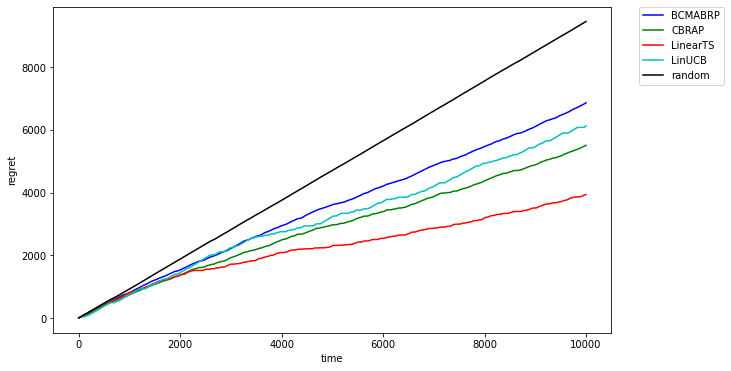

In [ ]:
experiment_bandit = ['LinearTS', 'LinUCB', 'random']
col = ['b', 'g', 'r', 'c', 'k', 'm', 'y']
times = 10000
i = 0
fig = plt.figure(figsize=[10, 6])
for bandit in experiment_bandit:
    # trend = regret_calculation(regret_all_BCMABRP[0]) #np.mean(cum_results[bandit][1], axis=0)
    trend = np.mean(cum_results[bandit], axis =0) #cum_results[bandit][0]
    plt.plot(range(times), trend, c=col[i], ls='-', label=bandit)
    plt.xlabel('time')
    plt.ylabel('regret')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes = plt.gca()
    # axes.set_ylim([0, 1])
    #plt.title("Regret Bound with respect to T")
    i += 1
plt.show()

In [ ]:
fig.savefig("drive/MyDrive/P2/Results/Plot.png", format = 'png', dpi = 300)